# Pre-Process Data and Train Neural Network

In [23]:
# Importing necessary libraries for data handling, model building, scaling, and visualization
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.utils import shuffle

# Load the dataset
input = pd.read_csv('Shuffled_Combined_Data.csv')

# Select the features for the model
X = input[['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']]

# Define a mapping for posture labels to numerical values for easier handling by the model
posture_map = {
    'supine': 1,
    'prone': 2,
    'side': 3,     # Lying on the side (either right or left)
    'sitting': 4,
    'unknown': 5
}

# Apply the mapping to the 'Posture' column to replace posture labels with numeric values
input['Posture'] = input['Posture'].map(posture_map)

# Assign the target variable (y) to the 'Posture' column with categorical encoding
y = input['Posture']
y = to_categorical(y - 1, num_classes=5)  # 5 classes total: [supine, prone, side, sitting, unknown]

# Split data into training, validation, and test sets
X_train, X_dump, y_train, y_dump = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_dump, y_dump, test_size=0.5, random_state=42)

# Initialize a StandardScaler to normalize the input features for all sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform
X_val_scaled = scaler.transform(X_val)          # Only transform (don't fit) validation data
X_test_scaled = scaler.transform(X_test)        # Only transform (don't fit) test data

# Function to create sensor data by replacing the other sensors with 0
def create_sensor_data(sensor_type, X):
    # Create a copy of the data to preserve the original dataset
    X_sensor = X.copy()

    if sensor_type == 'accel':  # Use only accelerometer data
        X_sensor[['Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']] = 0  # Set gyro and mag to 0
    elif sensor_type == 'gyro':  # Use only gyroscope data
        X_sensor[['Accel_X', 'Accel_Y', 'Accel_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']] = 0  # Set accel and mag to 0
    elif sensor_type == 'mag':  # Use only magnetometer data
        X_sensor[['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']] = 0  # Set accel and gyro to 0

    return X_sensor


# Create datasets with individual sensors
X_train_accel = create_sensor_data('accel', X_train)  # Only accelerometer data
X_train_gyro = create_sensor_data('gyro', X_train)    # Only gyroscope data
X_train_mag = create_sensor_data('mag', X_train)      # Only magnetometer data

# Create datasets where all sensors are present
X_train_all = X_train.copy()  # This contains all sensor data

# Combine the individual sensor data and all-sensor data into one dataset for training
X_train_combined = pd.concat([X_train_accel, X_train_gyro, X_train_mag, X_train_all])

# Convert the labels into a pandas DataFrame to allow concatenation
y_train_df = pd.DataFrame(y_train)

# Create labels by repeating the labels 3 times for individual sensors and 1 time for all sensors
y_train_combined = pd.concat([y_train_df] * 3 + [y_train_df] * 1, ignore_index=True)

# Shuffle the training data to avoid any ordering

X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)

X_train_scaled_combined = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Function to create, compile, and train a model
def build_and_train_model(X_train, y_train, X_val, y_val, activation='relu'):
    model = Sequential()  # Start a new model
    model.add(Dense(64, input_dim=X_train.shape[1], activation=activation))  # First layer with 64 neurons
    model.add(Dense(32, activation=activation))  # Second layer with 32 neurons
    model.add(Dense(5, activation='softmax'))  # Output layer with 5 classes for posture

    # Compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model with 40 epochs, batch size of 32, and validation data
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

    return model, history

# Training the model on the modified data (with individual sensors and all sensors combined)
print("\nTraining with ReLU activation:\n")
model_relu, history_relu = build_and_train_model(X_train_scaled_combined, y_train_combined, X_val_scaled, y_val, activation='relu')


# Model Evaluation: Test the model on the test set
test_loss, test_acc = model_relu.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc}")



Training with ReLU activation:

Epoch 1/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6026 - loss: 1.0838 - val_accuracy: 0.9864 - val_loss: 0.0609
Epoch 2/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7529 - loss: 0.6067 - val_accuracy: 0.9939 - val_loss: 0.0187
Epoch 3/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7706 - loss: 0.5309 - val_accuracy: 0.9973 - val_loss: 0.0107
Epoch 4/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7834 - loss: 0.4998 - val_accuracy: 0.9986 - val_loss: 0.0081
Epoch 5/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7977 - loss: 0.4734 - val_accuracy: 0.9973 - val_loss: 0.0103
Epoch 6/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8083 - loss: 0.4562 - val_accuracy: 0.9973 - val_loss: 0.0112
Epoch 7/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8103 - loss: 0.4605 - val_accuracy: 0.9986 - val_loss: 0.0102
Epoch 8/100
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy:

# Plotting Statistics of the Model

In [24]:
print("\nModel Evaluation with ReLU:")
test_loss_relu, test_acc_relu = model_relu.evaluate(X_test_scaled, y_test)
print(f"Test accuracy with ReLU activation: {test_acc_relu}")



Model Evaluation with ReLU:
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0656
Test accuracy with ReLU activation: 0.9965986609458923


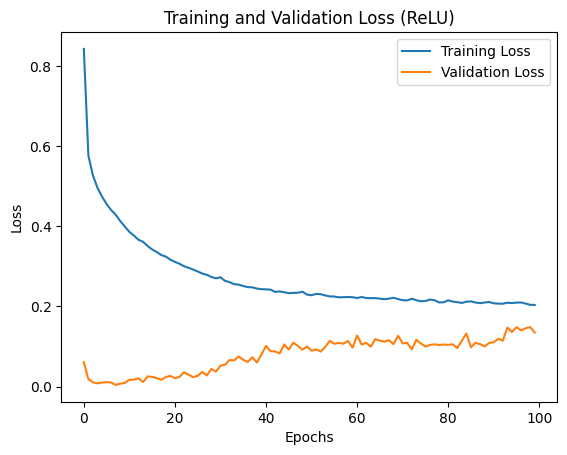

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_relu.history['loss'], label='Training Loss')
plt.plot(history_relu.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss (ReLU)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

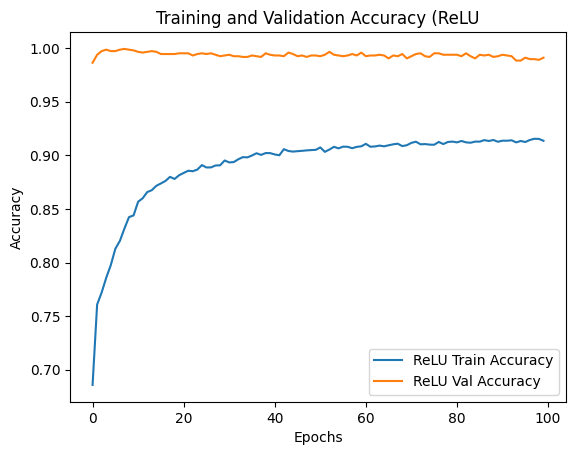

In [26]:
# Plot the training and validation accuracy for each activation function
plt.plot(history_relu.history['accuracy'], label='ReLU Train Accuracy')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Accuracy')
plt.title("Training and Validation Accuracy (ReLU")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Manual Testing

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore') # hide warnings for cleaner output

# Initialize LabelEncoder and set classes for posture
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['supine', 'prone', 'side', 'sitting', 'unknown'])

# Define the actual postures for the new samples
actual_postures = ['prone', 'supine', 'side', 'side', 'unknown','sitting']

# Sample input data
new_samples = np.array([
    [-0.14,0.04,-0.99,0.06,-0.31,0.06,42.00,-13.00,-68.00],  # prone
    [0.02,-0.02,1.00,-0.06,0.18,-1.04,35.00,29.00,29.00],    # supine
    [-0.03,0.98,0.11,2.44,-0.06,-0.18,59.00,-12.00,16.00],   # side
    [0.02,-1.01,0.08,0.43,0.31,0.00,-39.00,9.00,14.00],      # side
    [0.50,0.57,0.63,0.18,0.24,0.61,17.00,-28.00,9.00],       # unknown
    [-0.99,-0.01,-0.01,0,0,0,46.00,42.00,-22.00],            # sitting
])

# Prepare an empty DataFrame to store the results
results = pd.DataFrame(columns=['Sample', 'Actual Posture', 'Activation', 'Predicted Posture'])

# Predict using each model
for model, activation in zip([model_relu], ['ReLU']):
    for idx, new_sample in enumerate(new_samples):
        # Normalize the sample
        normalized_sample = scaler.transform(new_sample.reshape(1, -1))

        # Predict and get class index with highest probability
        prediction_probs = model.predict(normalized_sample)
        predicted_class_index = np.argmax(prediction_probs, axis=1)

        # Decode to posture label
        predicted_posture = label_encoder.inverse_transform(predicted_class_index)[0]

        # Create a new row as a dictionary
        new_row = {
            'Sample': idx + 1,
            'Actual Posture': actual_postures[idx],
            'Activation': activation,
            'Predicted Posture': predicted_posture
        }

        # Concatenate the new row to the results DataFrame
        results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# Display the results
results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


,Sample,Actual Posture,Activation,Predicted Posture
0,1,prone,ReLU,prone
1,2,supine,ReLU,supine
2,3,side,ReLU,side
3,4,side,ReLU,side
4,5,unknown,ReLU,unknown
5,6,sitting,ReLU,sitting


# Save and Download Model

In [28]:
import warnings
warnings.filterwarnings('ignore') # hide warnings for cleaner output
# decided on relu activation due to high accuracy
model_relu.save('model.h5')
import tensorflow as tf

# Load your trained model
Keras_Model_Out = tf.keras.models.load_model('model.h5')
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(Keras_Model_Out)
tfliteModel = converter.convert()

# Save the converted model to a file
with open('model.tflite', 'wb') as f:
    f.write(tfliteModel)

Keras_Model_Out.evaluate(X_test_scaled, y_test)

Saved artifact at '/tmp/tmpsun_lwbu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133185320596608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133185319073424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133185321939040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133185321929360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133185319541696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133185319535184: TensorSpec(shape=(), dtype=tf.resource, name=None)
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9981 - loss: 0.0656


[0.07688417285680771, 0.9965986609458923]

In [29]:
# Install xxd tool to convert binary files to C-style hex format
!apt-get install xxd

# Convert the model.tflite file to a C++ header file that contains the model as a byte array
# This is useful for embedding the model into an Arduino or other embedded systems
!xxd -i model.tflite > model_pak.cpp

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xxd is already the newest version (2:8.2.3995-1ubuntu2.19).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [30]:
# Import the files module from Google Colab, which provides methods for downloading files
from google.colab import files

# Download the 'model_pak.cpp' file to the local machine
# This file contains the embedded model data in C++ format, which we can then use in our embedded system
files.download('model_pak.cpp')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>